In [1]:
import torch
import pyro

from typing import Dict, List
from scipy.stats import entropy
from scipy.stats import beta
import pyro.distributions as dist

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def plot_from_nodes(nodes, filters: Dict[str, float] = None, nodes_to_plot: List[str] = None):

    values = {key: nodes[key]['value'].float().detach().cpu().numpy() for key in nodes.keys() if nodes[key]['name'] != 'samples'}

    valuesDF = pd.DataFrame(values)

    if filters is not None:
        for key in filters.keys():
            valuesDF = valuesDF[valuesDF[key] == filters[key]]

    if nodes_to_plot is None:
        nodes_to_plot = values.keys()

    for key in nodes_to_plot:
        plt.figure()
        plt.hist(valuesDF[key], bins=20, alpha=0.7, color='blue', density=True)
        plt.title(key)
        plt.xlabel('value')
        plt.ylabel('frequency')
        sns.despine()
        plt.show()  

    return valuesDF


In [3]:
# same as explained in weight_into_notebook
def weight(posterior: List[float], base = 2) -> float:

    grid_length = len(posterior)
    x = np.linspace(0, 1, grid_length)
    uniform = beta.pdf(x, 1, 1)
    entropy_uniform = entropy(uniform, base=base)
    entropy_posterior = entropy(posterior, base=base)
    return 1 - entropy_posterior/entropy_uniform


In [4]:

def tinbox_model():
   
    prob_father = pyro.sample("prob_father", dist.Beta(1.0, 1.0))
    father = pyro.sample("father", dist.Bernoulli(prob_father))
     
    # confession slightly more probable if father tries to save the son
    prob_confession = pyro.deterministic("prob_confession", 0.7 + father *  - 0.1, event_dim=0)
    confession = pyro.sample("confession", dist.Bernoulli(prob_confession))

    # knife fingerprints match slightly more probable if father tries to save the son
    prob_knife  = pyro.deterministic("prob_knife", 0.6 + father * - 0.1, event_dim=0)
    knife = pyro.sample("knife", dist.Bernoulli(prob_knife))

    # high angle more probable if father is guilty
    prob_angle = pyro.deterministic("prob_angle", 0.3 + father * 0.4, event_dim=0)
    angle = pyro.sample("angle", dist.Bernoulli(prob_angle))


    # imagined tinbox evidence
    # father's fingerprints
    prob_father_fingerprints = pyro.deterministic("prob_fingerprints", 1e-9 + father * 0.99, event_dim=0)
    prob_son_fingerprints = pyro.deterministic("prob_son_fingerprints", 1e-9 + (1-father) * 0.99, event_dim=0)

    father_fingerprints = pyro.sample("father_fingerprints", dist.Bernoulli(prob_father_fingerprints))
    son_fingerprints = pyro.sample("son_fingerprints", dist.Bernoulli(prob_son_fingerprints))




with pyro.poutine.trace() as tr:
    with pyro.plate("samples", size = 1000000):
        tinbox_model()

nodes = tr.trace.nodes


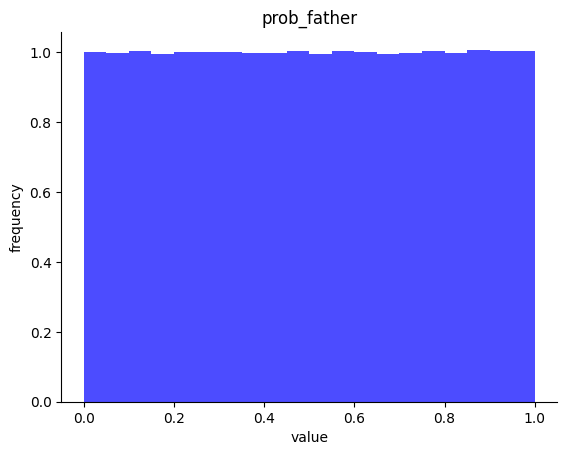

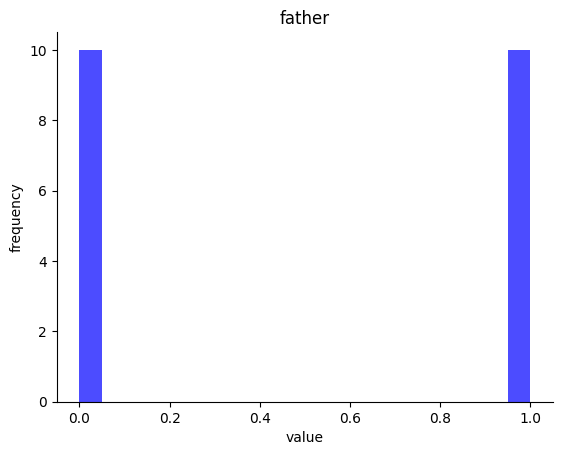

father, prior [0.49976402521133423, 0.500236]
weight_father_prior 0.0


In [5]:
# prior 
priorDf = plot_from_nodes(nodes, nodes_to_plot=["prob_father", "father"])

prior_father = [1 - priorDf["father"].mean(), priorDf["father"].mean()]
print("father, prior", prior_father)

prior_weight_father = weight(prior_father)
print("weight_father_prior", prior_weight_father.round(3))


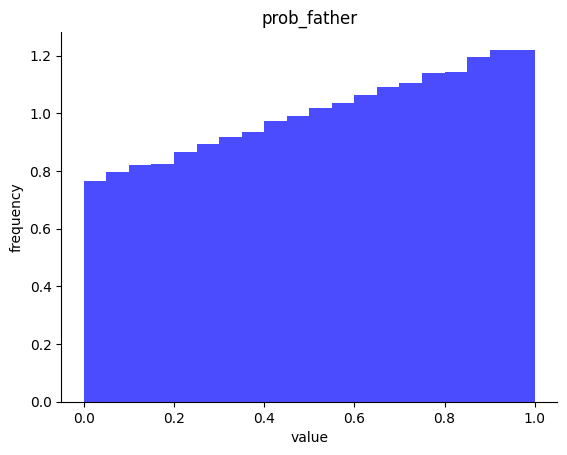

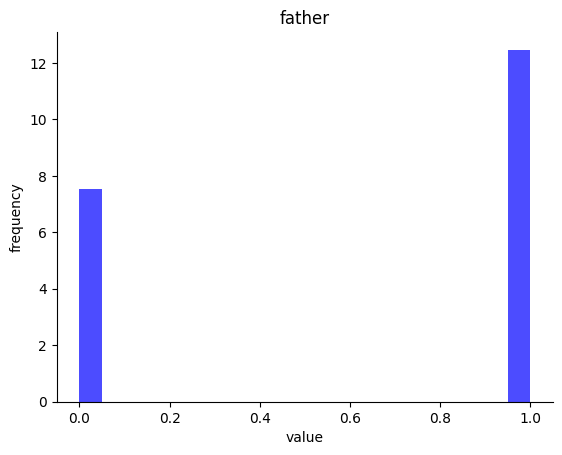

evidence_wo_tinbox_father [0.3766598105430603, 0.6233402]
weight_father_wo_tinbox 0.04435124793949663
difference in weights 0.04435108726913828


In [6]:
# evidence so far, no tinbox

evidence_wo_tinbox_Df = plot_from_nodes(nodes, 
                                        filters = {"confession": 1,
                                                   "knife": 1,
                                                   "angle": 1,
                                        },
                                        nodes_to_plot=["prob_father", "father"])


evidence_wo_tinbox_father = [1 - evidence_wo_tinbox_Df["father"].mean(), evidence_wo_tinbox_Df["father"].mean()]
evidence_wo_tinbox_weight_father = weight(evidence_wo_tinbox_father)
print("evidence_wo_tinbox_father", evidence_wo_tinbox_father)
print("weight_father_wo_tinbox",  evidence_wo_tinbox_weight_father)

print("difference in weights", evidence_wo_tinbox_weight_father - prior_weight_father)

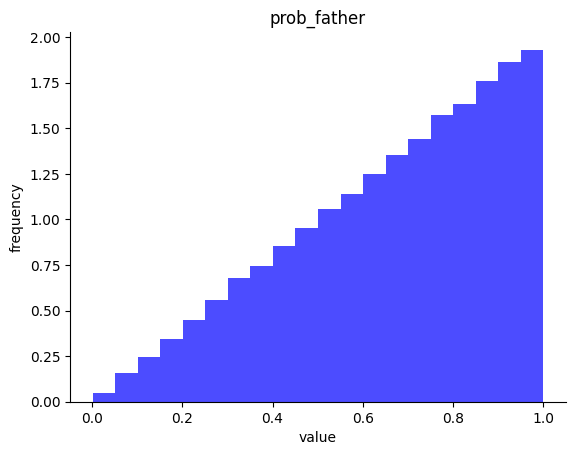

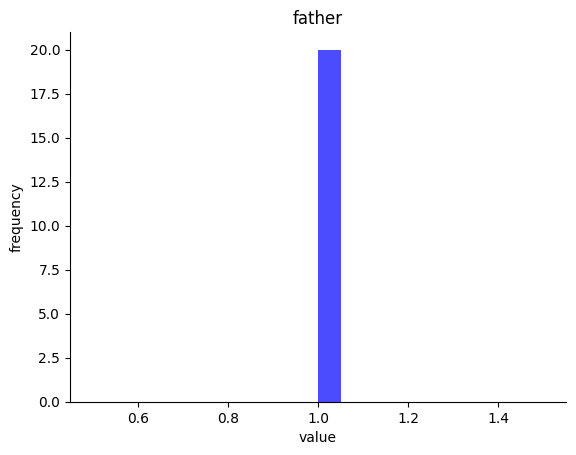

evidence_tinbox_f_father [0.0, 1.0]
evidence_tinbox_f_weight_father 1.0
difference in weights 0.9556487520605034


In [7]:
# suppose father's fingerprints on the tinbox

evidence_tinbox_f_df = plot_from_nodes(nodes,
                                        filters = {"confession": 1,
                                                   "knife": 1,
                                                   "angle": 1,
                                                   "father_fingerprints": 1,
                                                   "son_fingerprints": 0,
                                        },
                                        nodes_to_plot=["prob_father", "father"])




evidence_tinbox_f_father = [1 - evidence_tinbox_f_df["father"].mean(), evidence_tinbox_f_df["father"].mean()]
evidence_tinbox_f_weight_father = weight(evidence_tinbox_f_father)
print("evidence_tinbox_f_father", evidence_tinbox_f_father)
print("evidence_tinbox_f_weight_father", evidence_tinbox_f_weight_father)

print("difference in weights", evidence_tinbox_f_weight_father - evidence_wo_tinbox_weight_father)

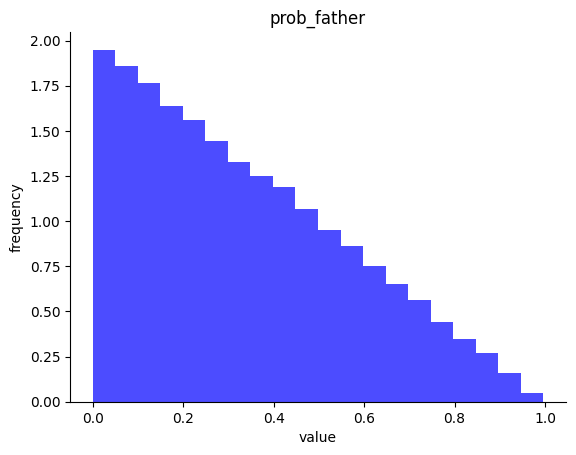

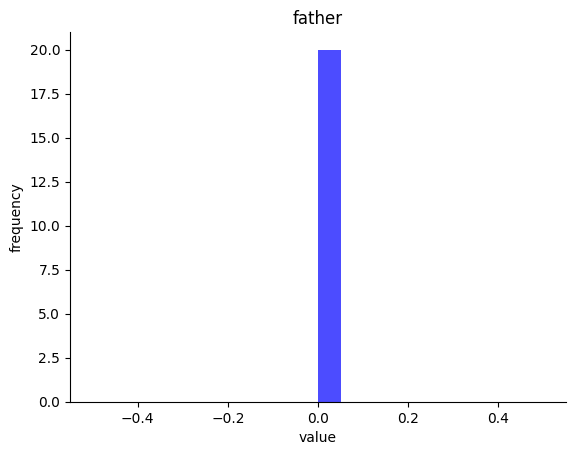

evidence_tinbox_f_father [1.0, 0.0]
evidence_tinbox_f_weight_father 1.0
difference in weights 0.9556487520605034


In [8]:
# suppose son's fingerprints on the tinbox, not father's

evidence_tinbox_s_df = plot_from_nodes(nodes,
                                        filters = {"confession": 1,
                                                   "knife": 1,
                                                   "angle": 1,
                                                   "father_fingerprints": 0,
                                                   "son_fingerprints": 1,
                                        },
                                        nodes_to_plot=["prob_father", "father"])




evidence_tinbox_s_father = [1 - evidence_tinbox_s_df["father"].mean(), evidence_tinbox_s_df["father"].mean()]
evidence_tinbox_s_weight_father = weight(evidence_tinbox_s_father)
print("evidence_tinbox_f_father", evidence_tinbox_s_father)
print("evidence_tinbox_f_weight_father", evidence_tinbox_s_weight_father)

print("difference in weights", evidence_tinbox_s_weight_father - evidence_wo_tinbox_weight_father)

In [ ]:
# something to think about and experiment with potentially

# def samples_to_normalized_counts(samples, grid_length=100):

#     linspace = np.linspace(0, 1, grid_length)
#     counts, _ = np.histogram(samples, bins=linspace)
#     normalized_counts = counts / grid_length
#     return normalized_counts